<a href="https://colab.research.google.com/github/CarolKSD/Forecasting_Stocks/blob/main/cleanspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install arch
!pip install statsmodels
!pip install shap

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import shap
import datetime
import tensorflow as tf

In [4]:
# Step 1: Data Collection
def fetch_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.reset_index(inplace=True)  # Reset the index to make 'Date' a column
    return data

# Configuration
start_date = "2018-01-01"
end_date = "2025-01-25"
stock_ticker = "CLSK"
bitcoin_ticker = "BTC-USD"

# Fetch data for stock and Bitcoin
stock_data = fetch_stock_data(stock_ticker, start_date, end_date)
bitcoin_data = fetch_stock_data(bitcoin_ticker, start_date, end_date)

# Fill missing values
stock_data['Close'] = stock_data['Close'].fillna(method='ffill')
bitcoin_data['Close'] = bitcoin_data['Close'].fillna(method='ffill')

# Rename the Bitcoin 'Close' column to 'Bitcoin_Close'
stock_data.rename(columns={'Close': 'Stock_Close'}, inplace=True)
bitcoin_data.rename(columns={'Close': 'Bitcoin_Close'}, inplace=True)

# Merge DataFrames on 'Date'
data = pd.merge(stock_data[['Date', 'Stock_Close']], bitcoin_data[['Date', 'Bitcoin_Close']], on='Date', how='inner')

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Display the first rows to ensure both columns exist
print(data.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price      Stock_Close Bitcoin_Close
Ticker            CLSK       BTC-USD
Date                                
2018-01-02        24.4  14982.099609
2018-01-03        24.4  15201.000000
2018-01-04        24.4  15599.200195
2018-01-05        24.4  17429.500000
2018-01-08        24.4  15170.099609



<ipython-input-4-ed32c6987759>:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data['Close'] = stock_data['Close'].fillna(method='ffill')
<ipython-input-4-ed32c6987759>:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  bitcoin_data['Close'] = bitcoin_data['Close'].fillna(method='ffill')
<ipython-input-4-ed32c6987759>:26: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data = pd.merge(stock_data[['Date', 'Stock_Close']], bitcoin_data[['Date', 'Bitcoin_Close']], on='Date', how='inner')


In [5]:
data

Price,Stock_Close,Bitcoin_Close
Ticker,CLSK,BTC-USD
Date,,
2018-01-02,24.40,14982.099609
2018-01-03,24.40,15201.000000
2018-01-04,24.40,15599.200195
2018-01-05,24.40,17429.500000
2018-01-08,24.40,15170.099609
...,...,...
2025-01-16,11.18,99756.906250
2025-01-17,11.87,104462.039062


In [6]:
# Drop the 'Ticker' level from the MultiIndex
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.droplevel(level='Ticker')

# Create a copy of the DataFrame with a new, simple index
data = data.copy()
data.columns = data.columns.get_level_values(0)  # Flatten the MultiIndex
data.columns.name = None  # Remove the name attribute

In [7]:
# Step 2: Feature Engineering
data['Daily_Returns'] = data['Stock_Close'].pct_change()
data['MA_10'] = data['Stock_Close'].rolling(window=10).mean()
data['MA_50'] = data['Stock_Close'].rolling(window=50).mean()

# Relative Strength Index (RSI)
def compute_RSI(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = compute_RSI(data['Stock_Close'])

# Temporal features
#data['Weekday'] = data.index.weekday  # Monday=0, Sunday=6
#data['Month'] = data.index.month
#data['DayOfYear'] = data.index.dayofyear
#data['WeekOfYear'] = data.index.isocalendar().week

# Lagged Features
data['Stock_Close_Lag1'] = data['Stock_Close'].shift(1)
data['Stock_Close_Lag7'] = data['Stock_Close'].shift(7)
data['Stock_Close_Lag30'] = data['Stock_Close'].shift(30)
data['Bitcoin_Close_Lag1'] = data['Bitcoin_Close'].shift(1)
data['Bitcoin_Close_Lag7'] = data['Bitcoin_Close'].shift(7)

# Rolling Statistics
data['Stock_Close_RollingStd10'] = data['Stock_Close'].rolling(window=10).std()
data['Stock_Close_RollingStd30'] = data['Stock_Close'].rolling(window=30).std()

# Price Differences and Ratios
data['Price_Diff'] = data['Stock_Close'] - data['Stock_Close'].shift(1)
data['Stock_Bitcoin_Ratio'] = data['Stock_Close'] / data['Bitcoin_Close']

data.dropna(inplace=True)

In [8]:
data

,Stock_Close,Bitcoin_Close,Daily_Returns,MA_10,MA_50,RSI,Stock_Close_Lag1,Stock_Close_Lag7,Stock_Close_Lag30,Bitcoin_Close_Lag1,Bitcoin_Close_Lag7,Stock_Close_RollingStd10,Stock_Close_RollingStd30,Price_Diff,Stock_Bitcoin_Ratio
Date,,,,,,,,,,,,,,,
2018-03-16,12.00,8338.349609,-0.245283,15.510,20.4440,0.000000,15.90,15.90,24.40,8300.860352,9965.570312,1.233288,4.282115,-3.90,0.001439
2018-03-19,15.70,8630.650391,0.308333,15.490,20.2700,48.684212,12.00,15.90,24.40,8338.349609,9395.009766,1.227871,4.111387,3.70,0.001819
2018-03-20,15.70,8913.469727,0.000000,15.470,20.0960,48.684212,15.70,15.90,24.40,8630.650391,9337.549805,1.222066,3.911075,0.00,0.001761
2018-03-21,15.70,8929.280273,0.000000,15.450,19.9220,48.684212,15.70,15.90,24.40,8913.469727,9205.120117,1.215867,3.676344,0.00,0.001758
2018-03-22,15.70,8728.469727,0.000000,15.430,19.7480,48.684212,15.70,15.90,24.40,8929.280273,9194.849609,1.209270,3.400074,0.00,0.001799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-16,11.18,99756.906250,-0.001786,10.549,12.4737,54.234532,11.20,11.43,14.52,100504.492188,102078.085938,0.622244,1.592516,-0.02,0.000112
2025-01-17,11.87,104462.039062,0.061717,10.791,12.5151,61.562025,11.18,10.71,13.95,99756.906250,96922.703125,0.617908,1.525578,0.69,0.000114
2025-01-21,10.96,106146.265625,-0.076664,10.807,12.5231,58.600587,11.87,10.09,14.68,104462.039062,95043.523438,0.620234,1.397282,-0.91,0.000103


       Stock_Close  Bitcoin_Close  Daily_Returns        MA_10        MA_50  \
count  1688.000000    1688.000000    1688.000000  1688.000000  1688.000000   
mean     12.861480   29657.905204       0.004894    12.874130    13.017624   
std      10.002602   23066.518767       0.129746     9.752592     9.229325   
min       1.050000    3242.484863      -0.521918     1.144000     1.521700   
25%       4.650000    9263.886230      -0.040715     4.696750     4.930175   
50%      10.650000   23947.567383      -0.002567    10.695500    10.754400   
75%      17.905000   44169.931641       0.034671    17.881500    17.678900   
max      73.000000  106146.265625       3.866667    55.495000    39.662800   

               RSI  Stock_Close_Lag1  Stock_Close_Lag7  Stock_Close_Lag30  \
count  1688.000000       1688.000000       1688.000000        1688.000000   
mean     47.941235         12.864140         12.881142          13.059975   
std      18.971460         10.002813         10.003858          10

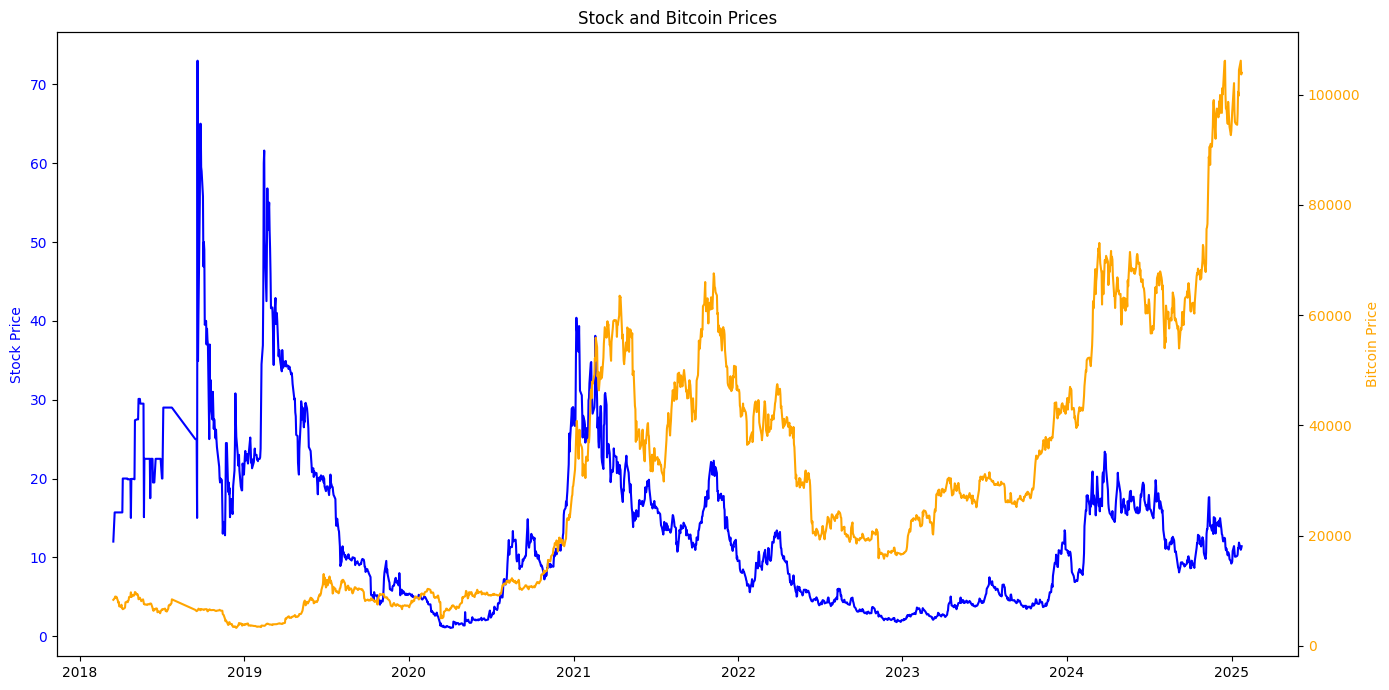

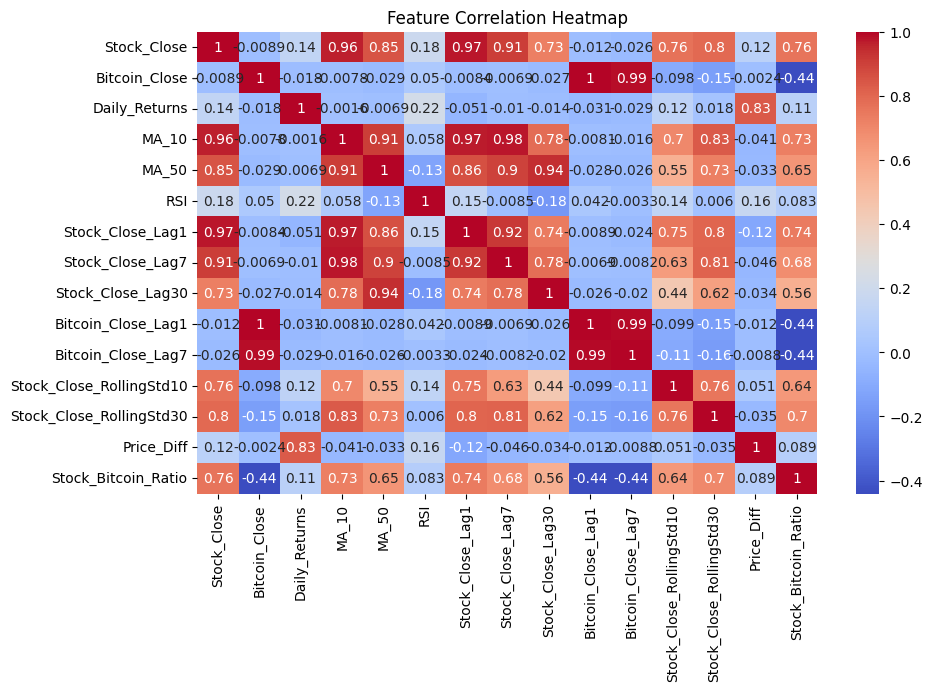

In [9]:
# Step 3: Exploratory Data Analysis (EDA)
print(data.describe())

# Dual axes for stock and Bitcoin prices
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Stock Price on the left y-axis
ax1.plot(data.index, data['Stock_Close'], color='blue', label='Stock Price')
ax1.set_ylabel('Stock Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Bitcoin Price on the right y-axis
ax2 = ax1.twinx()
ax2.plot(data.index, data['Bitcoin_Close'], color='orange', label='Bitcoin Price')
ax2.set_ylabel('Bitcoin Price', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Titles and legends
plt.title('Stock and Bitcoin Prices')
fig.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [10]:
# Step 4: Data Preprocessing
scaler = RobustScaler()
scaled_data = scaler.fit_transform(data)

# Create time series windows
window_size = 90
X, y = [], []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i])
    y.append(scaled_data[i, 0])  # Target: Stock_Close

X, y = np.array(X), np.array(y)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [11]:
# Step 5: Statistical Model (ARIMA)
arima_train = data['Stock_Close'][:train_size]
arima_test = data['Stock_Close'][train_size:]

# Prepare data for ARIMA with exogenous variables
arima_train_exog = data[['Bitcoin_Close']][:train_size]  # Exogenous variable
arima_test_exog = data[['Bitcoin_Close']][train_size:]

# Create and fit the ARIMA model
arima_model = ARIMA(arima_train, exog=arima_train_exog, order=(5, 1, 0))
arima_fit = arima_model.fit()

# Forecast using the fitted model and exogenous variables
arima_forecast = arima_fit.forecast(steps=len(arima_test), exog=arima_test_exog)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [12]:
# Step 6: Traditional Machine Learning Model (Random Forest)
scaler_rf = MinMaxScaler()

X_rf_train = data.iloc[:train_size, 1:].values  # Exclude 'Stock_Close'
X_rf_test = data.iloc[train_size:, 1:].values
X_rf_train_scaled = scaler_rf.fit_transform(X_rf_train)  # Scale training data
X_rf_test_scaled = scaler_rf.transform(X_rf_test)

# Create and fit the Random Forest model with scaled features
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_rf_train_scaled, arima_train.values)

# Make predictions using the scaled test data
rf_predictions = rf_model.predict(X_rf_test_scaled)

In [13]:
# Step 7: Deep Learning Model (LSTM)
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.4),
    LSTM(50, return_sequences=False),
    Dropout(0.4),
    Dense(25),
    Dropout(0.4),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# LSTM Predictions
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(
    np.concatenate([lstm_predictions, np.zeros((len(lstm_predictions), scaled_data.shape[1] - 1))], axis=1)
)[:, 0]

# Reverse scaling for the test set
y_test_original = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), scaled_data.shape[1] - 1))], axis=1)
)[:, 0]

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.4860 - val_loss: 0.0310
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.2028 - val_loss: 0.0142
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.1324 - val_loss: 0.0111
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.1440 - val_loss: 0.0114
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.1297 - val_loss: 0.0164
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0811 - val_loss: 0.0087
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0851 - val_loss: 0.0096
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0905 - val_loss: 0.0134
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.0945 - val_loss: 0.0075
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.0883 - val_loss: 0.0099
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0746 - val_loss: 0.0071
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0808 - va

In [14]:
# Step 8: Evaluate Models
models = {
    'ARIMA': arima_forecast,
    'Random Forest': rf_predictions,
    'LSTM': lstm_predictions
}

metrics = {}
for model_name, predictions in models.items():
    # Align prediction lengths with y_test_original for all models
    predictions = predictions[:len(y_test_original)]
    mae = mean_absolute_error(y_test_original, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
    metrics[model_name] = {'MAE': mae, 'RMSE': rmse}
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

ARIMA - MAE: 5.22, RMSE: 6.41
Random Forest - MAE: 5.56, RMSE: 7.03
LSTM - MAE: 1.08, RMSE: 1.42


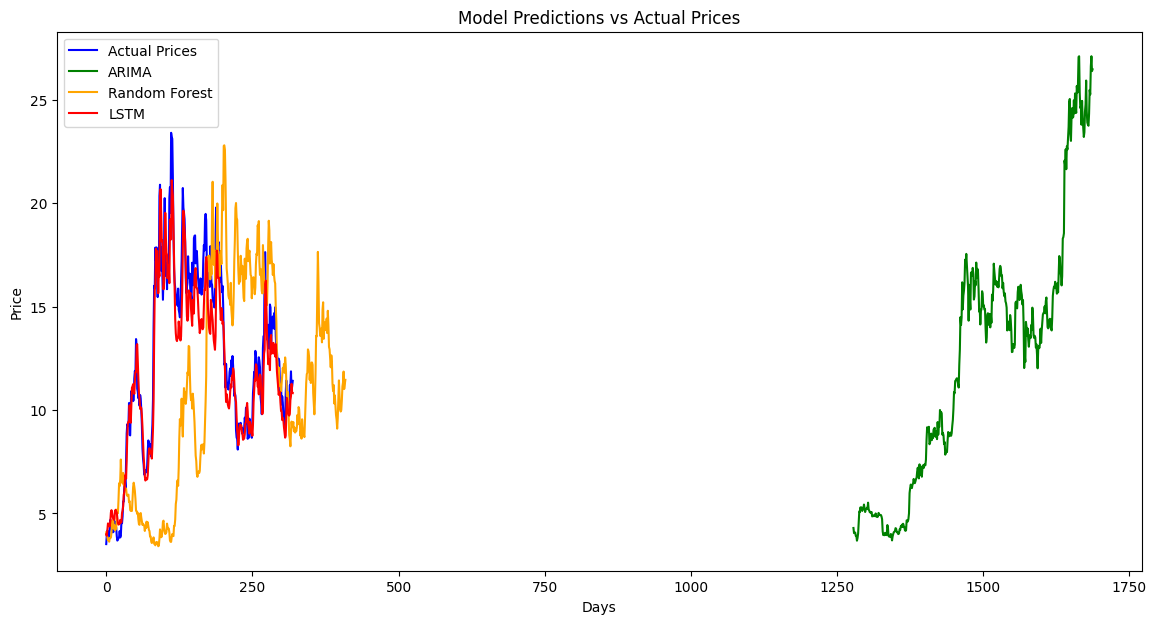

In [15]:
# Step 9: Visualize Results
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Prices', color='blue')
plt.plot(arima_forecast, label='ARIMA', color='green')
plt.plot(rf_predictions, label='Random Forest', color='orange')
plt.plot(lstm_predictions, label='LSTM', color='red')
plt.title('Model Predictions vs Actual Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

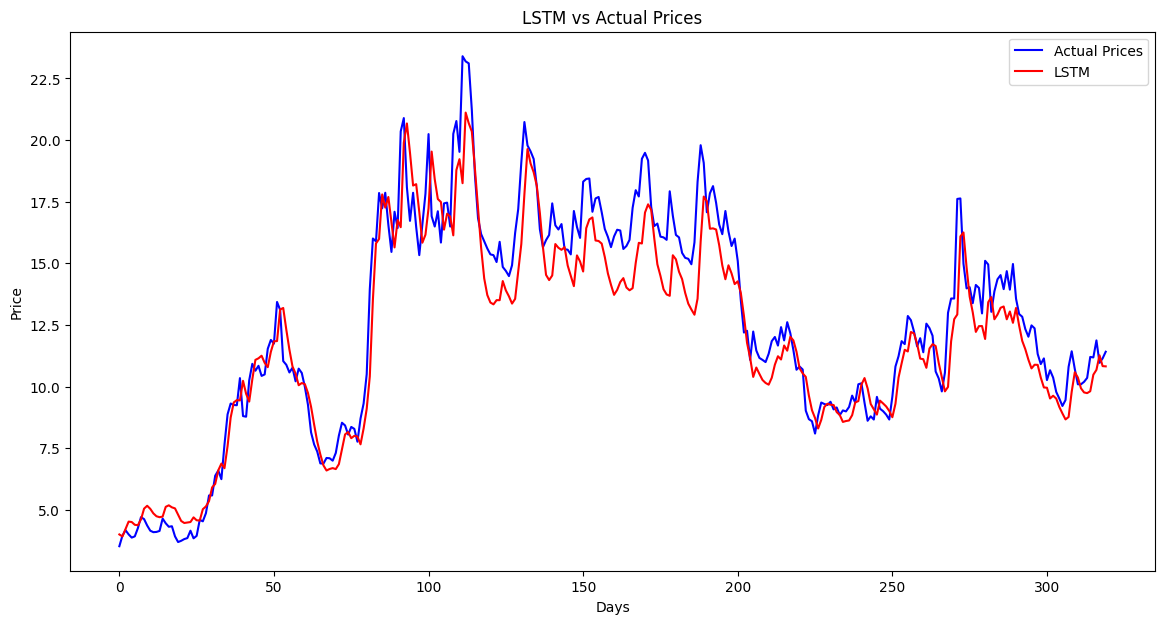

In [16]:
# Step 9: Visualize Results
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Prices', color='blue')
plt.plot(lstm_predictions, label='LSTM', color='red')
plt.title('LSTM vs Actual Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [17]:
# Step 10: Predict the Next Day (LSTM)
latest_data = scaled_data[-window_size:]
latest_data = np.expand_dims(latest_data, axis=0)

next_day_prediction = lstm_model.predict(latest_data)
next_day_prediction = scaler.inverse_transform(
    np.concatenate([next_day_prediction, np.zeros((1, scaled_data.shape[1] - 1))], axis=1)
)[:, 0]

print(f"Next Day Predicted Price (LSTM): {next_day_prediction[0]:.2f} USD")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
Next Day Predicted Price (LSTM): 10.95 USD


In [19]:
# Step 10: Predict the Next 7 Days (LSTM)
future_predictions = []

# Initialize current_data with the latest window_size data points from scaled_data
current_data = scaled_data[-window_size:].copy()

for _ in range(7):  # Forecast for 7 days
    current_data_reshaped = tf.reshape(tf.convert_to_tensor(current_data), [1, window_size, scaled_data.shape[1]])
    next_day_prediction = lstm_model.predict(current_data_reshaped)

    # Update current_data (NumPy array) by shifting and adding the prediction
    current_data[:-1] = current_data[1:]
    current_data[-1, 0] = next_day_prediction[0, 0]

    # Append the prediction to the list
    future_predictions.append(next_day_prediction[0, 0])  # Append prediction to the list

# Check if future_predictions is empty
if len(future_predictions) > 0:
    # Perform inverse transform if future_predictions is not empty
    future_predictions = scaler.inverse_transform(
        np.concatenate([np.array(future_predictions).reshape(-1, 1),
                        np.zeros((len(future_predictions), scaled_data.shape[1] - 1))], axis=1)
    )[:, 0]
else:
    print("No predictions were made.")

print(future_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[10.94854429 11.12218738 11.2961933  11.45376703 11.58862876 11.69992188
 11.78942298]
